# Table of contents
1. [Team members](#team)
2. [Libraries](#libraries)
3. [Exploring data](#exploring)
4. [Preprocessing data](#preprocessing)
5. [Questions](#questions)
    - [Question 1](#question-1)
    - [Question 2](#question-2)
    - [Question 3](#question-3)
    - [Question 4](#question-4)
    - [Question 5](#question-5)
6. [Modelling](#modelling)
    - [Data preparation](#modelling_preparation)
    - [Models: ](#models)
        - [Model 1 (change the number to the name of model. Ex: 1 -> Logistic Regression)](#model1)
    - [Evaluation](#evaluation)
7. [Reflection](#reflection)
    - [Difficulties during the project](#difficulties)
    - [Useful things learned](#useful)
    - [Plans to improve if have more time](#plans)
8. [References](#references)

<h1 id = "team">1. Team members</h1>
<style>
  table {
    margin: auto;
    width: 45%; /* Adjust the width as needed */
  }
  td {
    text-align: center;
    padding: 8px; /* Adding padding for better readability */
  }
  th
  {
    text-align: center;
  }
</style>

<table>
    <tr>
        <th> ID </th>
        <th> NAME </th>
    </tr>
    <tr>
        <td>22127148</td>
        <td>Dương Nhật Huy</td>
    </tr>
    <tr>
        <td>22127224</td>
        <td>Trương Thuận Kiệt</td>
    </tr>
    <tr>
        <td>22127257</td>
        <td>Phạm Minh Mẫn</td>
    </tr>
    <tr>
        <td>22127492</td>
        <td>Hồ Đăng Phúc</td>
    </tr>

<h1 id = "libraries"> 2. Libraries </h1>

In [367]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

<h1 id = "exploring"> 3. Exploring data</h1>

In [368]:
raw_data  = pd.read_csv('./Data/full_data.csv')

In [369]:
raw_data.head()

,Title,CriticScore,UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Formated name,Metascore,Userscore
0,L.A. Confidential,99%,94%,https://www.rottentomatoes.com/m/la_confidential,Cinema,"Kevin Spacey, Russell Crowe, Guy Pearce, James...",Curtis Hanson,"Crime, Drama",R,2h 16m,Warner Home Vídeo,"Sep 19, 1997","$35,000,000","$64,604,977","$126,204,977",l.a.confidential,91,8.6
1,The Godfather,97%,98%,https://www.rottentomatoes.com/m/the_godfather,Cinema,"Marlon Brando, Al Pacino, James Caan, Richard ...",Francis Ford Coppola,"Crime, Drama",R,2h 57m,Paramount Pictures,"Mar 15, 1972","$7,000,000","$136,479,994","$270,007,394",thegodfather,100,9.3
2,Casablanca,99%,95%,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",Michael Curtiz,Drama,PG,1h 42m,Warner Bros. Pictures,"Jan 23, 1943","$1,039,000","$10,462,500","$10,567,179",casablanca,100,8.7
3,Parasite,99%,90%,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Choi...",Bong Joon Ho,"Comedy, Mystery & Thriller, Drama",R,2h 12m,Neon,"May 30, 2019","$11,800,000","$53,369,745","$253,267,858",parasite,97,8.9
4,Top Gun: Maverick,96%,99%,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"Tom Cruise, Miles Teller, Jennifer Connelly, J...",Joseph Kosinski,"Action, Adventure",PG-13,2h 11m,Paramount Pictures,"May 20, 2022","$170,000,000","$718,732,821","$1,464,400,233",topgun:maverick,78,8.4


### Number of rows and columns

In [370]:
shape = raw_data.shape  
shape

(5106, 18)

### The meaning of each line

- Each line of the dataset is a record of a movie, and all records include various features of the movie like Name, Genres, Cast, Budget, Revenue, Runtime, etc

### Duplicated rows

In [371]:
num_duplicates = raw_data.duplicated().sum()
num_duplicates

0

Phew, luckily no duplicated rows

### The meaning of each column

### Data type of each column

In [372]:
dtype = raw_data.dtypes
dtype

Title                object
CriticScore          object
UserScore            object
Link                 object
PlatformReleased     object
Cast                 object
Director             object
Genre                object
Rating               object
Runtime              object
Studio               object
Release Date         object
Production Budget    object
Domestic Gross       object
Worldwide Gross      object
Formated name        object
Metascore            object
Userscore            object
dtype: object

As can be seen that, all types of each colum are currently objects. Therefore, those needs re-typing

### Data retyping

+ Title, Link, PlatformReleased, Studio : These are meant to be string, so there no need to convert it

+ CriticScore and UserScore are numbers, therfore we convert them into numerical datatype

Note : All numerical value are kept in float not interger because numpy require float to store nan

In [373]:
#Remove '%' notation and keep the score
def get_score_percentage(score_str):
    if pd.isna(score_str) or score_str == 'nan' or score_str == 'NaN':
        return np.nan
    elif re.match(r'^\d{1,3}%$', score_str):
            return float(score_str[:-1])
    return np.nan

raw_data['CriticScore'] = raw_data['CriticScore'].apply(get_score_percentage)
raw_data['UserScore'] = raw_data['UserScore'].apply(get_score_percentage)

+ Convert MetaScore and UserScore into Numerical datatype too

In [374]:
#Check if a string is a valid number because there are invalid value in Metascore and Userscore
def get_score(score_str):
    if pd.isna(score_str) or score_str == 'nan' or score_str == 'NaN':
        return np.nan
    elif re.match(r'^-?\d+(\.\d+)?$', score_str):
        return float(score_str)
    return np.nan
    
raw_data['Metascore'] = raw_data['Metascore'].apply(get_score)
raw_data['Userscore'] = raw_data['Userscore'].apply(get_score)


+ Because a movie may have many Actors, many Director and different Gern, we split them and store into a list

In [375]:
#Split string by comma seperated
def split_item(string):
    if pd.isna(string) or string == 'nan' or string == 'NaN':
        return pd.NA
    else:
        return string.split(', ')
    
raw_data['Cast'] = raw_data['Cast'].apply(split_item)
raw_data['Genre'] = raw_data['Genre'].apply(split_item)
raw_data['Director'] = raw_data['Director'].apply(split_item)

+ There are 10 different ratings, so we convert them into Pandas Categorial

In [376]:
raw_data['Rating'] = raw_data['Rating'].astype('category')

+ We convert Runtime into dictionary consists of hours and minutes for easier operating

In [377]:


# Collect runtime information and convert it into dictionary
def get_runtime(runtime_str):
    if pd.isna(runtime_str) or runtime_str == 'nan' or runtime_str == 'NaN':
        return pd.NA
    else:
        runtime = runtime_str.split()

        if 'h' in runtime[0]:   
            hours = int(runtime[0].split('h')[0])
            minutes = int(runtime[1].split('m')[0])
        else:
            hours = 0
            minutes = int(runtime[0].split('m')[0])
        return {'hours' : hours, 'minutes': minutes}

raw_data['Runtime'] = raw_data['Runtime'].apply(get_runtime)


+ We convert release date into Pandas Datetime

In [378]:
month_dict = {'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Collect date string and store it into datetime format
def parse_datetime(date_str):
    if pd.isna(date_str) or date_str == 'nan' or date_str == 'NaN' or date_str == 'Unknown':
        return pd.NaT
    else:
        date = date_str.replace(',','').split()
        if len(date) == 1:
            year = int(date[0])
            return pd.to_datetime(year, format ='%Y')
        elif len(date) == 2:
            month = month_dict[date[0]]
            year = int(date[1])
            day = 1
            return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')
        else:
            month = month_dict[date[0]]
            day = int(date[1])
            year = int(date[2])
            return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')

raw_data['Release Date'] = raw_data['Release Date'].apply(parse_datetime)
    

+ Finally, convert Budgets and Grossess into numerical datatype and we are done

In [379]:
# Replace $ notation, replace comma and get the value
def parse_money(money_str):
    if pd.isna(money_str) or money_str == 'nan' or money_str == 'NaN':
        return np.nan
    else:
        money_str = money_str.replace('$','').replace(',','')
        return float(money_str)

raw_data['Production Budget'] = raw_data['Production Budget'].apply(parse_money)         
raw_data['Domestic Gross'] = raw_data['Domestic Gross'].apply(parse_money)
raw_data['Worldwide Gross'] = raw_data['Worldwide Gross'].apply(parse_money)

+ Rename UserScore, Userscrore columns and drop Formated name columns because we dont use it

In [380]:
raw_data.rename(columns={'UserScore' : 'Tomatoes UserScore', 'Userscore' : 'Meta UserScore', 'CriticScore' : 'Tomatoes CriticScore', 'MetaScore': 'Meta CriticScore'}, inplace=True)

raw_data = raw_data.drop('Formated name', axis=1)

In [381]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Title                 5106 non-null   object        
 1   Tomatoes CriticScore  4129 non-null   float64       
 2   Tomatoes UserScore    4523 non-null   float64       
 3   Link                  5106 non-null   object        
 4   PlatformReleased      5106 non-null   object        
 5   Cast                  5074 non-null   object        
 6   Director              5071 non-null   object        
 7   Genre                 5060 non-null   object        
 8   Rating                4015 non-null   category      
 9   Runtime               5036 non-null   object        
 10  Studio                5059 non-null   object        
 11  Release Date          5031 non-null   datetime64[ns]
 12  Production Budget     5106 non-null   float64       
 13  Domestic Gross    

In [382]:
raw_data.head()

,Title,Tomatoes CriticScore,Tomatoes UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Metascore,Meta UserScore
0,L.A. Confidential,99.0,94.0,https://www.rottentomatoes.com/m/la_confidential,Cinema,"[Kevin Spacey, Russell Crowe, Guy Pearce, Jame...",[Curtis Hanson],"[Crime, Drama]",R,"{'hours': 2, 'minutes': 16}",Warner Home Vídeo,1997-09-19,35000000.0,64604977.0,1.262050e+08,91.0,8.6
1,The Godfather,97.0,98.0,https://www.rottentomatoes.com/m/the_godfather,Cinema,"[Marlon Brando, Al Pacino, James Caan, Richard...",[Francis Ford Coppola],"[Crime, Drama]",R,"{'hours': 2, 'minutes': 57}",Paramount Pictures,1972-03-15,7000000.0,136479994.0,2.700074e+08,100.0,9.3
2,Casablanca,99.0,95.0,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"[Humphrey Bogart, Ingrid Bergman, Paul Henreid...",[Michael Curtiz],[Drama],PG,"{'hours': 1, 'minutes': 42}",Warner Bros. Pictures,1943-01-23,1039000.0,10462500.0,1.056718e+07,100.0,8.7
3,Parasite,99.0,90.0,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"[Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Cho...",[Bong Joon Ho],"[Comedy, Mystery & Thriller, Drama]",R,"{'hours': 2, 'minutes': 12}",Neon,2019-05-30,11800000.0,53369745.0,2.532679e+08,97.0,8.9
4,Top Gun: Maverick,96.0,99.0,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"[Tom Cruise, Miles Teller, Jennifer Connelly, ...",[Joseph Kosinski],"[Action, Adventure]",PG-13,"{'hours': 2, 'minutes': 11}",Paramount Pictures,2022-05-20,170000000.0,718732821.0,1.464400e+09,78.0,8.4


### Numerical column exploration

For columns with numeric data types, calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- The min
- The lower quartile
- The median
- The upper quartile
- The max
After calculating, give **visualization** to help get deeper understanding of data, from that graph/chart give some comments on the values' distribution of that column

#### Tomatoes CriticsScore

- Missing Ratio

In [383]:
print("Percentage of missing values: ", raw_data['Tomatoes CriticScore'].isna().mean()*100)

Percentage of missing values:  19.134351743047397


- Correlation among other numerical features

In [384]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import ttest_ind

mlb = MultiLabelBinarizer()
raw_data_tmp = raw_data.copy()
raw_data_tmp['Genre'] = raw_data_tmp['Genre'].fillna("")
genre_onehot = pd.DataFrame(mlb.fit_transform(raw_data_tmp['Genre']), columns=mlb.classes_, index=raw_data_tmp.index)

rating_onehot = pd.get_dummies(raw_data_tmp['Rating'], prefix='Rating').astype(int)

raw_data_tmp = pd.concat([raw_data_tmp, genre_onehot, rating_onehot], axis=1)
raw_data_tmp = raw_data_tmp.drop(['Genre', 'Rating'], axis=1)

# Conduct t-tests between missing and non-missing groups for 'Tomatoes CriticScore'
p_values = {}
for column in raw_data_tmp.columns:
    if column != 'Tomatoes CriticScore' and np.issubdtype(raw_data_tmp[column].dtype, np.number):
        missing_group = raw_data_tmp[raw_data_tmp['Tomatoes CriticScore'].isna()][column]
        non_missing_group = raw_data_tmp[~raw_data_tmp['Tomatoes CriticScore'].isna()][column]

        if len(missing_group) > 0 and len(non_missing_group) > 0:
            ttest_result = ttest_ind(missing_group, non_missing_group, nan_policy='omit')
            p_values[column] = ttest_result.pvalue

# Convert p-values to a DataFrame and sort for easy viewing
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Column', 'pvalue'])
p_values_sorted = p_values_df.sort_values(by='pvalue', ascending=False)
print("T-test p-values between missing and non-missing groups for 'Tomatoes CriticScore':")
print(p_values_sorted)

significant_features = p_values_sorted[p_values_sorted['pvalue'] < 0.05]
num_significant = significant_features.shape[0]
total_features = p_values_sorted.shape[0]

# Calculate the proportion of significant features
proportion_significant = num_significant / total_features

print(f"Proportion of significant features: {proportion_significant:.2f}")

T-test p-values between missing and non-missing groups for 'Tomatoes CriticScore':
                  Column        pvalue
8              Animation  7.757713e-01
9                  Anime  6.331468e-01
29                Sports  6.267054e-01
15  Faith & Spirituality  6.267054e-01
17               Foreign  6.267054e-01
19               Holiday  2.981110e-01
20                Horror  2.793797e-01
39          Rating_TV-MA  2.785175e-01
24               Musical  2.132383e-01
33          Rating_NC-17  1.978649e-01
14                 Drama  1.974160e-01
25    Mystery & Thriller  1.968717e-01
12                 Crime  6.487590e-02
26                 Other  3.979249e-02
30                   War  3.676100e-02
32              Rating_G  2.419578e-02
31               Western  1.580981e-02
38           Rating_TV-G  1.051493e-02
23                 Music  9.429270e-03
22                LGBTQ+  5.428654e-03
27               Romance  3.474896e-03
4              Metascore  2.863810e-03
18               His

Most of p-values are < 0.05, suggesting that there is no significant difference between the groups with and without Tomatoes CriticScore and rate of p-values is 0.66, which is quite high<br>
It is likely that the missingness of Tomatoes CriticScore is **MAR** 

- Distribution of values

<Axes: title={'center': 'Tomatoes Critic Score'}, ylabel='Frequency'>

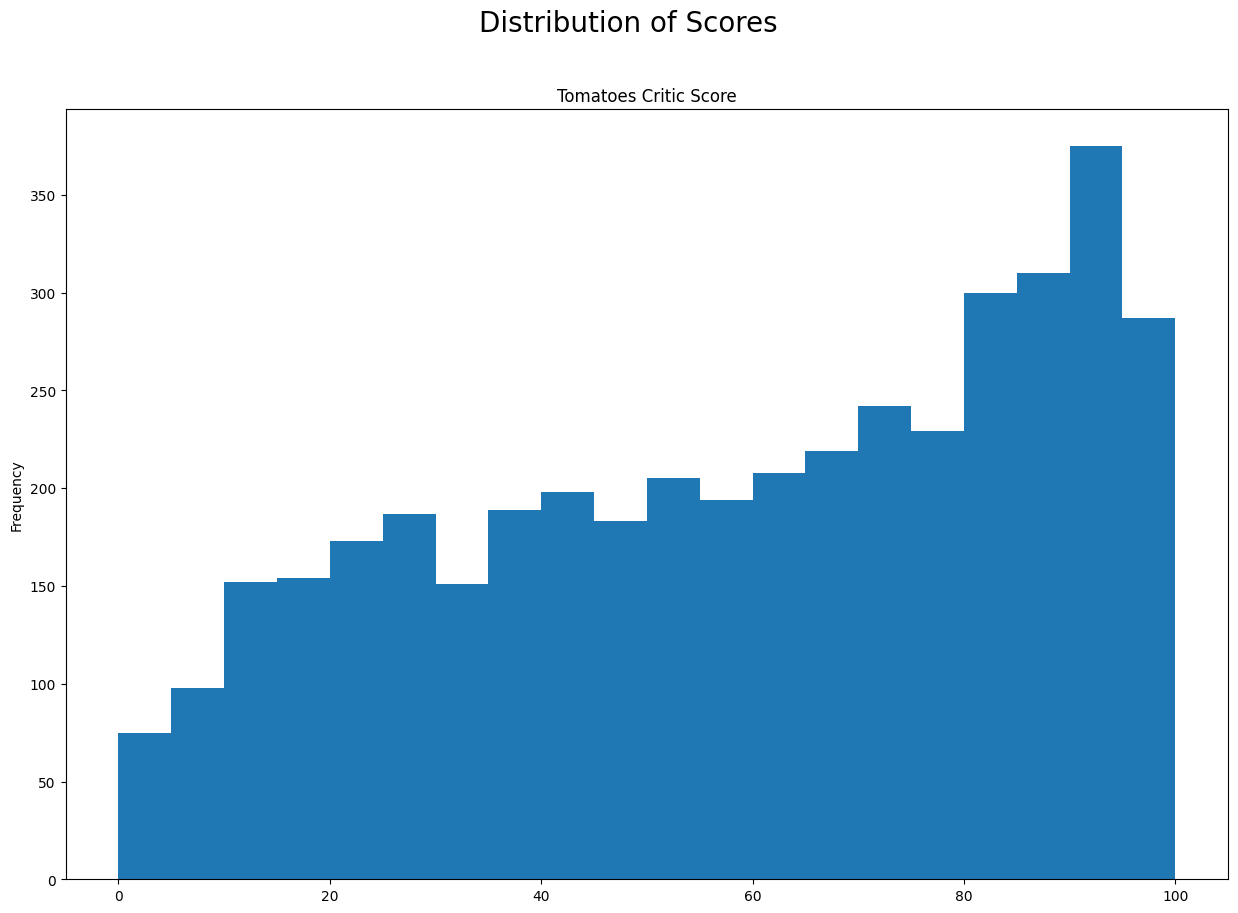

In [385]:
# Bar chart of scores
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
raw_data['Tomatoes CriticScore'].plot(kind='hist', title='Tomatoes Critic Score', bins=20)


- Descriptive Statistics

In [386]:
# The mean of Critics_Score
from scipy.stats import skew, kurtosis, sem

# Load necessary data from raw_data['CriticScore'] 
scores = raw_data['Tomatoes CriticScore']

# Basic Measures
mean = scores.mean()                                # Arithmetic Mean
median = scores.median()                            # Median
mode = scores.mode().values[0] if not scores.mode().empty else None  # Mode (if exists)

# Quantiles
quartiles = scores.quantile([0.25, 0.5, 0.75]).values  # Quartiles (Q1, Q2 (median), Q3)
percentiles = scores.quantile([0.1, 0.9]).values       # 10th and 90th Percentiles
deciles = scores.quantile([i/10 for i in range(1, 10)]).values  # Deciles (10th to 90th percentiles)

# Range and IQR
data_range = [scores.min(), scores.max()]

# Standard Error of the Mean
standard_error = sem(scores)

print("Mean: ", mean)
print("Median: ", median)
print("Mode: ", mode)
print("Quartiles: ", quartiles)
print("Percentiles: ", percentiles)
print("Deciles: ", deciles)
print("Range: ", data_range)


Mean:  58.367885686606925
Median:  62.0
Mode:  93.0
Quartiles:  [35. 62. 83.]
Percentiles:  [17. 93.]
Deciles:  [17. 29. 41. 51. 62. 71. 80. 87. 93.]
Range:  [0.0, 100.0]


**Mean (58.37):** On average, movies tend to receive a critic score around 58.37 out of 100.

**Median (62):** The median being higher than the mean suggests a positive skew in the distribution, meaning there are more movies with lower scores compared to higher scores.

**Mode (93):** The most frequent critic score is 93. This could be due to a few movies that received exceptionally high ratings.

**Quartiles:**

-   Q1 (35): 25% of the movies have a critic score of 35 or lower.
-   Q2 (Median, 62): 50% of the movies have a critic score of 62 or lower.
-   Q3 (83): 75% of the movies have a critic score of 83 or lower.
    
**Percentiles:**

- P10 (17): 10% of the movies have a critic score of 17 or lower.
- P90 (93): 90% of the movies have a critic score of 93 or lower.

**Deciles:** Movies tend to receive quite equal user scores from rotten tomatoes.

**Range (0-100):** This indicates that the critic scores range from 0 to 100, which is expected for a rating system.

**Overall, the summary statistics suggest a distribution that is skewed towards lower scores, with a few outliers on the higher end.**

#### Tomatoes UserScore

- Missing Ratio

In [387]:
print("Percentage of missing values: ", raw_data['Tomatoes UserScore'].isna().mean()*100)

Percentage of missing values:  11.417939678809244


- Correlation among other numerical features

In [388]:
p_values = {}

for column in raw_data_tmp.columns:
    if column != 'Tomatoes UserScore' and np.issubdtype(raw_data_tmp[column].dtype, np.number):
        missing_group = raw_data_tmp[raw_data_tmp['Tomatoes UserScore'].isna()][column]
        non_missing_group = raw_data_tmp[~raw_data_tmp['Tomatoes UserScore'].isna()][column]

        if len(missing_group) > 0 and len(non_missing_group) > 0:
            # Perform the t-test
            ttest_result = ttest_ind(missing_group, non_missing_group, nan_policy='omit')
            # Store the p-value in the dictionary
            p_values[column] = ttest_result.pvalue

# Convert the dictionary to a DataFrame for easier sorting
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Column', 'pvalue'])
print("T-test p-values between missing and non-missing groups for 'Tomatoes CriticScore':")

# Sort the DataFrame by p-value
p_values_sorted = p_values_df.sort_values(by='pvalue', ascending=False)

# Print the sorted p-values
print(p_values_sorted)
significant_features = p_values_sorted[p_values_sorted['pvalue'] < 0.05]
print(len(significant_features))
num_significant = significant_features.shape[0]
total_features = p_values_sorted.shape[0]

# Calculate the proportion of significant features
proportion_significant = num_significant / total_features

print(f"Proportion of significant features: {proportion_significant:.2f}")

T-test p-values between missing and non-missing groups for 'Tomatoes CriticScore':
                  Column        pvalue
39          Rating_TV-MA  9.768950e-01
38           Rating_TV-G  8.113520e-01
24               Musical  7.887967e-01
15  Faith & Spirituality  7.196164e-01
29                Sports  7.196164e-01
37          Rating_TV-14  6.145822e-01
8              Animation  4.942390e-01
33          Rating_NC-17  3.419376e-01
19               Holiday  3.306256e-01
4              Metascore  3.132494e-01
9                  Anime  3.095978e-01
12                 Crime  1.945396e-01
31               Western  6.005794e-02
32              Rating_G  4.403612e-02
30                   War  4.154914e-02
27               Romance  2.883157e-02
23                 Music  2.632155e-02
0   Tomatoes CriticScore  1.996478e-02
5         Meta UserScore  1.207926e-02
25    Mystery & Thriller  1.143898e-02
22                LGBTQ+  9.267475e-03
17               Foreign  5.336372e-03
26                 O

Most of p-values are < 0.05, suggesting that there is no significant difference between the groups with and without Tomatoes CriticScore and rate of p-values is 0.72, which is quite high<br>
It is likely that the missingness of Tomatoes UserScore is **MAR** 

- Distribution of values

<Axes: title={'center': 'Tomatoes User Score'}, ylabel='Frequency'>

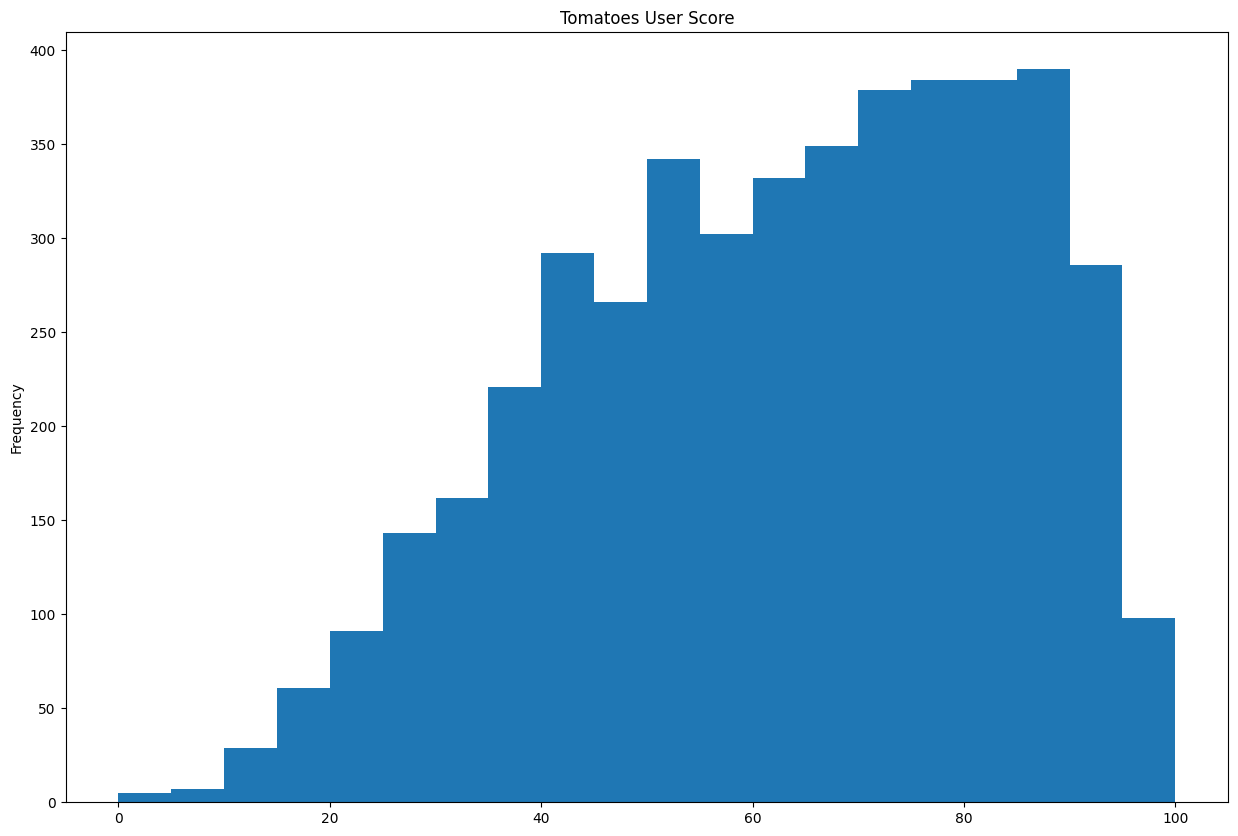

In [393]:
# Bar chart of scores
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
raw_data['Tomatoes UserScore'].plot(kind='hist', title='Tomatoes User Score', bins=20)


- Descriptive Statistics

In [392]:

# Load necessary data from raw_data['CriticScore'] 
scores = raw_data['Tomatoes UserScore']

# Basic Measures
mean = scores.mean()                                # Arithmetic Mean
median = scores.median()                            # Median
mode = scores.mode().values[0] if not scores.mode().empty else None  # Mode (if exists)

# Quantiles
quartiles = scores.quantile([0.25, 0.5, 0.75]).values  # Quartiles (Q1, Q2 (median), Q3)
percentiles = scores.quantile([0.1, 0.9]).values       # 10th and 90th Percentiles
deciles = scores.quantile([i/10 for i in range(1, 10)]).values  # Deciles (10th to 90th percentiles)

# Range
data_range = [scores.min(), scores.max()]

print("Mean: ", mean)
print("Median: ", median)
print("Mode: ", mode)
print("Quartiles: ", quartiles)
print("Percentiles: ", percentiles)
print("Deciles: ", deciles)
print("Range: ", data_range)


Mean:  62.45743975237674
Median:  65.0
Mode:  79.0
Quartiles:  [47. 65. 80.]
Percentiles:  [33. 89.]
Deciles:  [33. 43. 51. 58. 65. 71. 77. 83. 89.]
Range:  [0.0, 100.0]


**Mean (62.45):** On average, movies tend to receive a user score around 62.45 out of 100.

**Median (65):** The median being higher than the mean suggests a positive skew in the distribution, meaning there are more movies with lower scores compared to higher scores.

**&rarr; The mean (62.46) and median (65.0) values are relatively high, especially when considering a scoring scale that ranges from 0 to 100. This suggests that, on average, users are rating items above the midpoint (50), indicating a general tendency to rate positively**

**Mode (79):** The most frequent critic score is 79. This could be due to a few movies that received exceptionally high ratings.

**&rarr; A significant number of users have rated items favorably, as scores in the upper range are generally seen as positive**

**Quartiles:**

-   Q1 (47): 25% of the movies have a critic score of 47 or lower.
-   Q2 (Median, 65): 50% of the movies have a critic score of 65 or lower.
-   Q3 (80): 75% of the movies have a critic score of 89 or lower.
    
**&rarr; Many users are giving high ratings**
 
**Percentiles:**

- P10 (33): 10% of the movies have a critic score of 33 or lower.
- P90 (89): 90% of the movies have a critic score of 89 or lower.

**Deciles:** Movies tend to receive quite equal user score from rotten tomatoes.

**Range (0-100):** This indicates that the critic scores range from 0 to 100, which is expected for a rating system.

**While the presence of low scores does indicate that not all ratings are high, the overall trend in the statistics shows a clustering of scores towards the upper end. This is a common pattern seen in products or content that are generally well-received.**

#### Production Budget

- Missing Ratio

In [395]:
print("Percentage of missing values: ", raw_data['Production Budget'].isna().mean()*100)

Percentage of missing values:  0.0


Luckily, no missing values

- Distribution of values

<Axes: title={'center': 'Production Budget Over Time'}, xlabel='Release Date'>

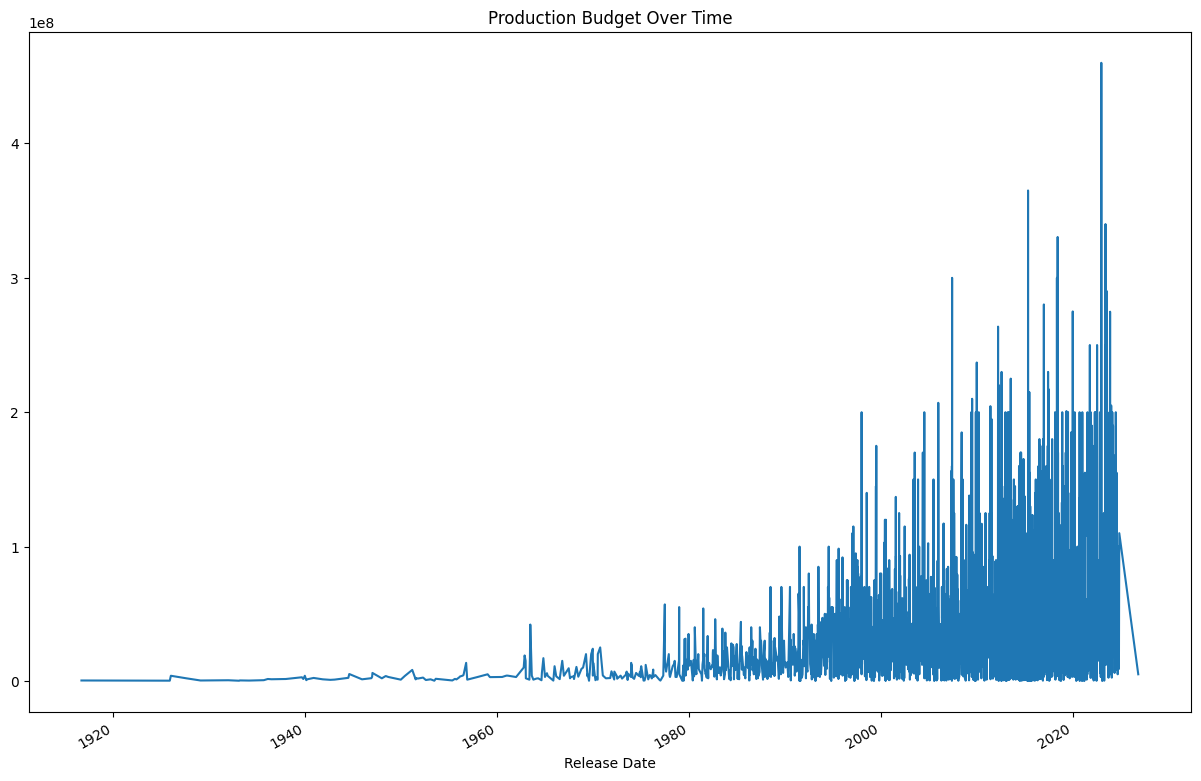

In [398]:
# Line graph of production budget over time
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
raw_data.groupby('Release Date')['Production Budget'].mean().plot(title='Production Budget Over Time', ax=ax)


- Descriptive Statistics

In [405]:

# Load necessary data from raw_data['CriticScore'] 
scores = raw_data['Production Budget']

# Basic Measures
mean = scores.mean()                                # Arithmetic Mean
median = scores.median()                            # Median
mode = scores.mode().values[0] if not scores.mode().empty else None  # Mode (if exists)

# Quantiles
quartiles = scores.quantile([0.25, 0.5, 0.75]).values  # Quartiles (Q1, Q2 (median), Q3)
percentiles = scores.quantile([0.1, 0.9]).values       # 10th and 90th Percentiles
deciles = scores.quantile([i/10 for i in range(1, 10)]).values  # Deciles (10th to 90th percentiles)

# Range
data_range = [scores.min(), scores.max()]

print("Mean: ", mean)
print("Median: ", median)
print("Mode: ", mode)
print("Quartiles: ", quartiles)
print("Percentiles: ", percentiles)
print("Deciles: ", deciles)
print("Range: ", data_range)


Mean:  33937859.52781042
Median:  18000000.0
Mode:  20000000.0
Quartiles:  [ 5000000. 18000000. 43750000.]
Percentiles:  [ 1200000. 85000000.]
Deciles:  [ 1200000.  3750000.  7000000. 12000000. 18000000. 25000000. 35000000.
 52000000. 85000000.]
Range:  [86.0, 460000000.0]


**Mean (33,937,859.53):** The average production budget is approximately 33,937,859.53. This indicates that, on average, films are funded at a substantial level, suggesting a significant investment in movie production.

**Median (18,000,000.0):** The median budget being 18,000,000.0 is notably lower than the mean, indicating a positive skew in the distribution. This suggests that while there are some films with very high budgets, many productions operate with more modest funding levels.

**→ The mean (33,937,859.53) and median (18,000,000.0) values suggest that while there are high-budget films, a significant number of productions are budgeted below the average, highlighting a diverse range of film financing.**

**Mode (20,000,000.0):** The mode of 20,000,000.0 indicates that this is the most common budget level among films. This clustering suggests a popular threshold for many productions, potentially reflecting industry standards or target funding levels.

**&rarr; A considerable number of films are being funded around this budget mark, indicating a trend in production financing.**

**Quartiles:**

- Q1 (5,000,000): 25% of films have budgets of 5,000,000 or lower, illustrating that a notable portion of productions are budget-conscious.
- Q2 (Median, 18,000,000): 50% of productions have budgets of 18,000,000 or lower, reinforcing that half of the films operate with relatively lower funding.
- Q3 (43,750,000): 75% of films have budgets below 43,750,000, suggesting that a significant number of productions are still well below the high-budget threshold.

**&rarr;** The quartile data indicates a wide range of budgets across the industry, with a substantial number of films receiving moderate to high levels of funding.

**Percentiles:**

P10 (1,200,000): 10% of films have budgets of 1,200,000 or lower, indicating that there are some very low-budget projects in the market.
P90 (85,000,000): 90% of films are budgeted below 85,000,000, showcasing that while high-budget films exist, the majority still fall within a lower range.

**Deciles:** The decile analysis indicates a fairly even distribution of budgets, suggesting that production funding is relatively accessible across a spectrum of films.

**Range (0-460,000,000):** The range of budgets from 86.0 to 460,000,000.0 confirms the presence of extreme outliers, reflecting the diversity in production financing strategies.

**Overall, while the presence of low budgets indicates that not all productions are highly funded, the majority of the data reflects a tendency towards higher investment in film production. This suggests a competitive landscape where a mix of both high-budget and lower-budget films coexist, potentially allowing for varied audience engagement and market opportunities.**

#### Domestic Gross

- Missing Ratio

In [402]:
print("Percentage of missing values: ", raw_data['Domestic Gross'].isna().mean()*100)

Percentage of missing values:  0.0


Luckily, no missing values

- Distribution of values

<Axes: title={'center': 'Domestic Gross Over Time'}, xlabel='Release Date'>

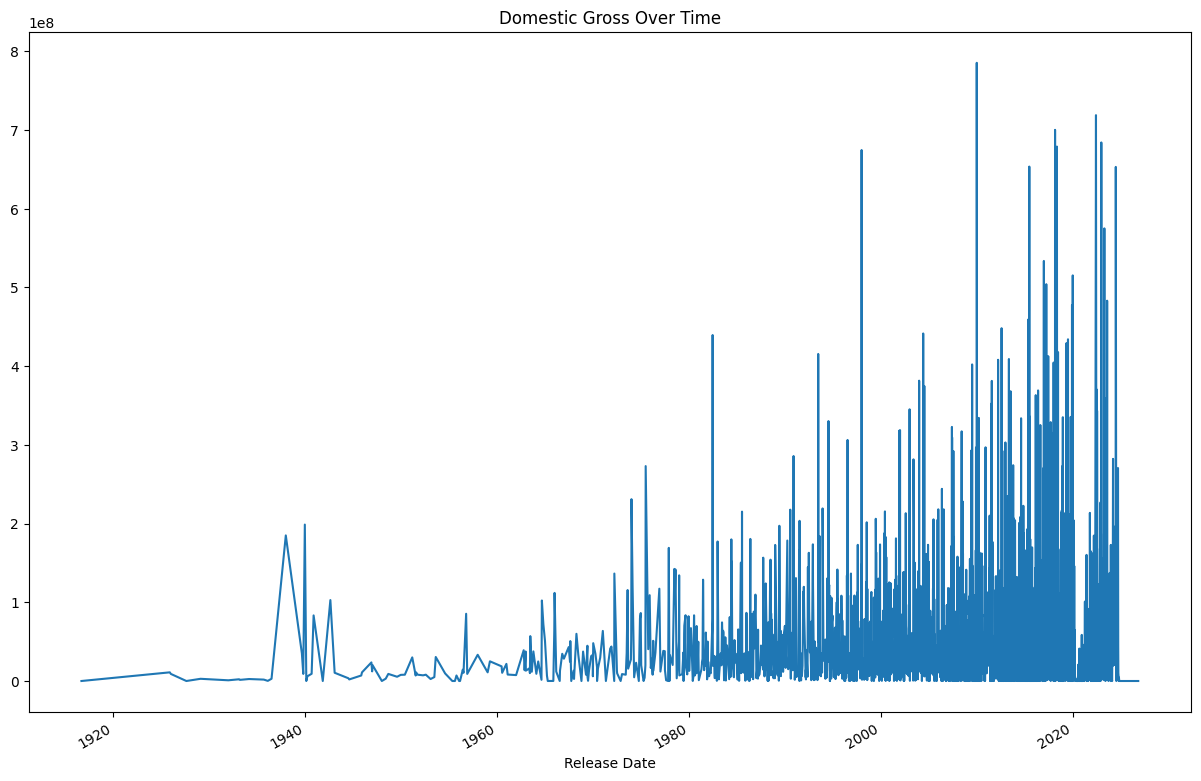

In [407]:
# Line graph of production budget over time
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
raw_data.groupby('Release Date')['Domestic Gross'].mean().plot(title='Domestic Gross Over Time', ax=ax)


Luckily, no missing values

- Descriptive Statistics

In [408]:
scores = raw_data['Domestic Gross']

# Basic Measures
mean = scores.mean()                                # Arithmetic Mean
median = scores.median()                            # Median
mode = scores.mode().values[0] if not scores.mode().empty else None  # Mode (if exists)

# Quantiles
quartiles = scores.quantile([0.25, 0.5, 0.75]).values  # Quartiles (Q1, Q2 (median), Q3)
percentiles = scores.quantile([0.1, 0.9]).values       # 10th and 90th Percentiles
deciles = scores.quantile([i/10 for i in range(1, 10)]).values  # Deciles (10th to 90th percentiles)

# Range
data_range = [scores.min(), scores.max()]

print("Mean: ", mean)
print("Median: ", median)
print("Mode: ", mode)
print("Quartiles: ", quartiles)
print("Percentiles: ", percentiles)
print("Deciles: ", deciles)
print("Range: ", data_range)


Mean:  43825054.271053664
Median:  17672451.0
Mode:  0.0
Quartiles:  [ 1431370.5 17672451.  54141177.5]
Percentiles:  [0.00000000e+00 1.16729653e+08]
Deciles:  [0.00000000e+00 4.09862000e+05 3.49233450e+06 9.63939000e+06
 1.76724510e+07 2.95000000e+07 4.45632045e+07 6.61840510e+07
 1.16729653e+08]
Range:  [0.0, 858373000.0]


**Mean (43,825,054.27):** The average domestic gross is approximately 43,825,054.27. This indicates that, on average, a reasonable return of films on domestic earnings across the production budget.

**Median (17,672,451.0):** The median budget being 17,672,451.0 is notably lower than the mean, indicating a positive skew in the distribution. This suggests that where a small number of films exceptionally high.

**→ Mean (43,825,054.27) and median (17,672,451.0) values suggest that while a few movies perform vary well domestically, the typical domestic gross is at very modest level**

**Mode (0.0):** The mode of 0.0 indicates that a number of films do not generate any domestic revenue, possibly due to limited or no domestic release.

**&rarr; This indicates that while many films have strong domestic performance, a portion either fails to secure domestic earnings or is released only internationally.**

**Quartiles:**

- Q1 (1,431,370.5): 25% of films have domestic return of 1,431,370.5 or lower, illustrating that a quarter of productions achieve limited domestic earnings.
- Q2 (Median, 17,672,451.0): 50% of domestic gross of 17,672,451.0 or lower, reinforcing the trend of moderate earnings for the majority.
- Q3 (54,141,177.5): 75% of films have budgets below 54,141,177.5, suggesting that only minority of film achieves high domestic success.

**&rarr;** The quartile data reflects a broad range of domestic gross figures, with most films falling below the highest-grossing tier.

**Percentiles:**

P10 (0.0): 10% of films can not generate domestic gross, reinforcing the mode value.
P90 (116,729,653): 90% of films gross are lower than 85,000,000, very high earnings are rare and achieved by a select few films.

**Deciles:** The decile analysis indicates a fairly consistent distribution of domestic gross, across the lower earnings tiers, with a significant increase only in the top deciles, highlighting the influence of high-grossing outliers.

**Range (0.0-858,373,000.0):** Underscores the variability in domestic gross potential, with a few films grossing exceptionally high amounts while others generate none.

**Overall, the descriptive statistics and the graph show a film industry where a small number of movies achieve high domestic grosses, while most perform modestly at the box office. The increase in domestic grosses over time reflects the industry's growing focus on blockbuster movies and larger theatrical releases, which tend to generate higher revenue. However, the strong skewness suggests that blockbuster successes are exceptions rather than the norm, highlighting the industry's reliance on a few high-grossing films to drive overall box office performance.**

**Mean (33,937,859.53):** The average production budget is approximately 33,937,859.53. This indicates that, on average, films are funded at a substantial level, suggesting a significant investment in movie production.

**Median (18,000,000.0):** The median budget being 18,000,000.0 is notably lower than the mean, indicating a positive skew in the distribution. This suggests that while there are some films with very high budgets, many productions operate with more modest funding levels.

**→ The mean (33,937,859.53) and median (18,000,000.0) values suggest that while there are high-budget films, a significant number of productions are budgeted below the average, highlighting a diverse range of film financing.**

**Mode (20,000,000.0):** The mode of 20,000,000.0 indicates that this is the most common budget level among films. This clustering suggests a popular threshold for many productions, potentially reflecting industry standards or target funding levels.

**&rarr; A considerable number of films are being funded around this budget mark, indicating a trend in production financing.**

**Quartiles:**

- Q1 (5,000,000): 25% of films have budgets of 5,000,000 or lower, illustrating that a notable portion of productions are budget-conscious.
- Q2 (Median, 18,000,000): 50% of productions have budgets of 18,000,000 or lower, reinforcing that half of the films operate with relatively lower funding.
- Q3 (43,750,000): 75% of films have budgets below 43,750,000, suggesting that a significant number of productions are still well below the high-budget threshold.

**&rarr;** The quartile data indicates a wide range of budgets across the industry, with a substantial number of films receiving moderate to high levels of funding.

**Percentiles:**

P10 (1,200,000): 10% of films have budgets of 1,200,000 or lower, indicating that there are some very low-budget projects in the market.
P90 (85,000,000): 90% of films are budgeted below 85,000,000, showcasing that while high-budget films exist, the majority still fall within a lower range.

**Deciles:** The decile analysis indicates a fairly even distribution of budgets, suggesting that production funding is relatively accessible across a spectrum of films.

**Range (0-460,000,000):** The range of budgets from 86.0 to 460,000,000.0 confirms the presence of extreme outliers, reflecting the diversity in production financing strategies.

**Overall, while the presence of low budgets indicates that not all productions are highly funded, the majority of the data reflects a tendency towards higher investment in film production. This suggests a competitive landscape where a mix of both high-budget and lower-budget films coexist, potentially allowing for varied audience engagement and market opportunities.**

### Categorical column exploration

For columns with non-numeric data types, you calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- Count no of unique values and no of element of each value (There is a column cast is quite difficult to explore, try to find a way)
-  Give **visualization** to help get deeper understanding of data, from that graph/chart or any collected information give some comments on the values' distribution of that column

In [391]:
# TODO

<h1 id = "preprocessing"> 4. Preprocessing data </h1>

<h1 id = "questions"> 5. Questions </h1>

<h2 id = question-1>5.1. Question 1</h2> 

<h2 id = question-2>5.2. Question 2</h2> 

<h2 id = question-3>5.3. Question 3</h2> 

<h2 id = question-4>5.4. Question 4</h2> 

<h2 id = question-5>5.5. Question 5</h2> 

<h1 id = "modelling">6. Modelling</h1>

<h2 id = "modelling_preparation">6.1. Data preparation</h2> 

<h2 id = "models">6.2. Models</h2> 

<h2 id = "models">6.2. Models</h2> 

<h3 id = "model1">6.2.1 Model 1</h3> 

<h2 id = >

<h2 id = "evaluation">6.3. Evaluation</h2> 

<h1 id = "reflection">7. Reflection</h1> 

<h2 id = "difficulties">7.1. Difficulties during the project</h2> 

<h2 id = "useful">7.2. Useful things learned</h2> 

<h2 id = "plans">7.3. Plans to improve if have more time</h2> 

<h1 id = "references">8. References</h1> 